In [1]:
import nltk
import numpy
import pandas
import sklearn
import sklearn.pipeline
import sklearn.grid_search
import sklearn.decomposition

# all 3 lines below should be uncommented
# import matplotlib.pyplot
# %matplotlib inline
# %matplotlib notebook

import sqlite3

import csshelper
import cssfeature
import csspipe
import csstransformer


db_path = './data.sqlite3'
sqlite_connection = sqlite3.connect(db_path)

In [2]:
data_reader_collection = [
        ('cExt', csshelper.CExtReader(sqlite_connection))
    
        , ('cNeu', csshelper.CNeuReader(sqlite_connection))
     
        , ('cAgr', csshelper.CAgrReader(sqlite_connection))
    
        , ('cCon', csshelper.CConReader(sqlite_connection))
    
        , ('cOpn', csshelper.COpnReader(sqlite_connection)) 
]

In [3]:

base_pipeline = sklearn.pipeline.Pipeline([     
    ('features', sklearn.pipeline.FeatureUnion(
          transformer_list=[
                  
            ('derived_string', sklearn.pipeline.Pipeline([
                ('part_of_speech', csstransformer.PartOfSpeech()),
                ('tf_idf_vect', sklearn.feature_extraction.text.TfidfVectorizer()),
            ])),
                 
                    
            ('derived_string (smileys)', sklearn.pipeline.Pipeline([
                ('smileys', csstransformer.Smileys()),
                ('tf_idf_vect', sklearn.feature_extraction.text.TfidfVectorizer(vocabulary=csstransformer.Smileys.smileys, 
                                                stop_words=None)),
            ])),
            
            ('derived_numeric', sklearn.pipeline.Pipeline([
              ('numeric_aggregator', csstransformer.Aggregator([
                    csstransformer.SentenceLength(),
                    csstransformer.NumberOfWords(),
                    csstransformer.NumberOfCommas(),
                    csstransformer.NumberOfDots(),
                    csstransformer.NumberOfSemicolons(),
                    csstransformer.NumberOfColons(),
                    csstransformer.LexicalDiversity(),
                    csstransformer.AverageWordLength(),
                    csstransformer.NumberOfFunctionalWords(),
                    csstransformer.NumberOfPronouns(),
                    csstransformer.NumberOfPropnames(),
                ])), 
              ('scaler', sklearn.preprocessing.MinMaxScaler()),
            ])),   
          ],
    )),
])

classifier_collection = [
        ('classifierLinearSVC', ('clf', sklearn.svm.LinearSVC(random_state = 5152))),
        ('classifierSVC', ('clf', sklearn.svm.SVC(cache_size=4096, random_state = 5152, 
                                                  kernel = "rbf", decision_function_shape = "ovr", 
                                                probability=True))),
        ('classifierNB', ('nb', sklearn.naive_bayes.MultinomialNB())),
        ('classifierBNB', ('bnb', sklearn.naive_bayes.BernoulliNB()))
]

def create_full_pipelines():
    return [
        (class_name, sklearn.pipeline.Pipeline(base_pipeline.steps + [classifier]))
        for class_name, classifier in classifier_collection
    ]

pipeline_collection = create_full_pipelines()


In [4]:
for pipe_name, pipe in pipeline_collection:
    print()
    print(pipe_name)
#     print(pipe.steps)


classifierLinearSVC

classifierSVC

classifierNB

classifierBNB


In [6]:
def apply_some_grid_search(pipe_name, pipeline, reader_description, reader):
    print("\nFOR: Pipeline: %s/%s" % (reader_description, pipe_name))

    data = reader.get_results()
    feature = data.iloc[:,0]
    label = data.iloc[:,1]

    split = sklearn.cross_validation.train_test_split(feature, label, train_size=0.66, 
    stratify=label, random_state=5152)

    x_train, x_test, y_train, y_test = split

    pipeline.fit(x_train, y_train)
    y_pred_trait = pipeline.predict(x_test)


    print("F1: ", sklearn.metrics.f1_score(y_test, y_pred_trait, labels=[0, 1], average='binary'))
    print("Precision: ", sklearn.metrics.average_precision_score(y_test, y_pred_trait, average='micro'))
    print("Recall: ", sklearn.metrics.recall_score(y_test, y_pred_trait, labels=[0, 1], average='binary'))
    print("Accuracy score: ", sklearn.metrics.accuracy_score(y_test, y_pred_trait))
    
    # uncomment below for confusion matrices
    #print(sklearn.metrics.classification_report(y_test, y_pred_trait))
    #print(sklearn.metrics.confusion_matrix(y_test, y_pred_trait))

In [7]:
for pipe_name, pipeline in pipeline_collection:
    for reader_description, reader in data_reader_collection:
        apply_some_grid_search(pipe_name, pipeline, reader_description, reader)
        
    print()
    print()


FOR: Pipeline: cExt/classifierLinearSVC
F1:  0.204635387224
Precision:  0.516343907749
Recall:  0.126484975542
Accuracy score:  0.582740213523

FOR: Pipeline: cNeu/classifierLinearSVC
F1:  0.0304182509506
Precision:  0.38845008475
Recall:  0.0158227848101
Accuracy score:  0.621886120996

FOR: Pipeline: cAgr/classifierLinearSVC
F1:  0.635431235431
Precision:  0.716686582834
Recall:  0.761027359017
Accuracy score:  0.536180308422

FOR: Pipeline: cCon/classifierLinearSVC
F1:  0.355274261603
Precision:  0.559548552401
Recall:  0.271788250484
Accuracy score:  0.546856465006

FOR: Pipeline: cOpn/classifierLinearSVC
F1:  0.852670976523
Precision:  0.871589561091
Recall:  1.0
Accuracy score:  0.743179122183



FOR: Pipeline: cExt/classifierSVC
F1:  0.0
Precision:  0.7121886121
Recall:  0.0
Accuracy score:  0.575622775801

FOR: Pipeline: cNeu/classifierSVC
F1:  0.0
Precision:  0.687425860024
Recall:  0.0
Accuracy score:  0.625148279953

FOR: Pipeline: cAgr/classifierSVC
F1:  0.693782684486
Pre

/usr/local/lib/python3.4/dist-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



FOR: Pipeline: cExt/classifierNB
it is in predict proba


<IPython.core.display.Javascript object>


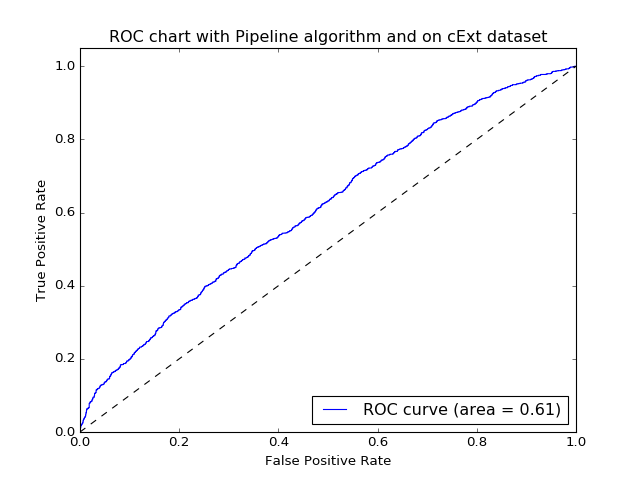

F1:  0.175460122699
Precision:  0.600246120696
Recall:  0.099930118798
Accuracy score:  0.601423487544

GRID SEARCH:
Best score: 0.590
Best parameters set:
	features__status__tf_idf_vect__ngram_range: (1, 1)

FOR: Pipeline: cNeu/classifierNB
it is in predict proba


<IPython.core.display.Javascript object>


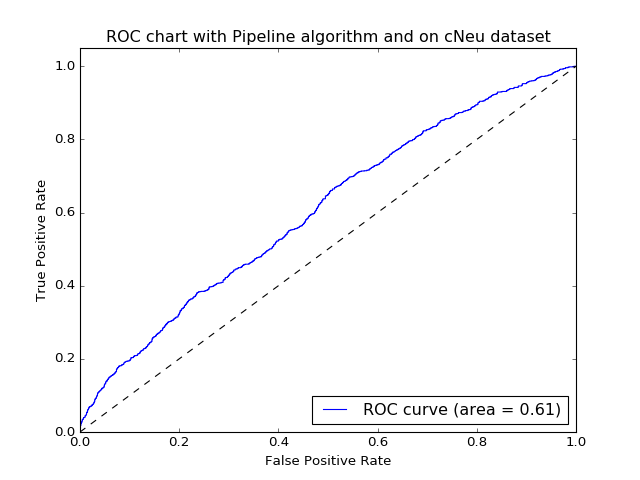

F1:  0.0476923076923
Precision:  0.625647395278
Recall:  0.0245253164557
Accuracy score:  0.632858837485

GRID SEARCH:
Best score: 0.626
Best parameters set:
	features__status__tf_idf_vect__ngram_range: (1, 1)

FOR: Pipeline: cAgr/classifierNB
it is in predict proba


<IPython.core.display.Javascript object>


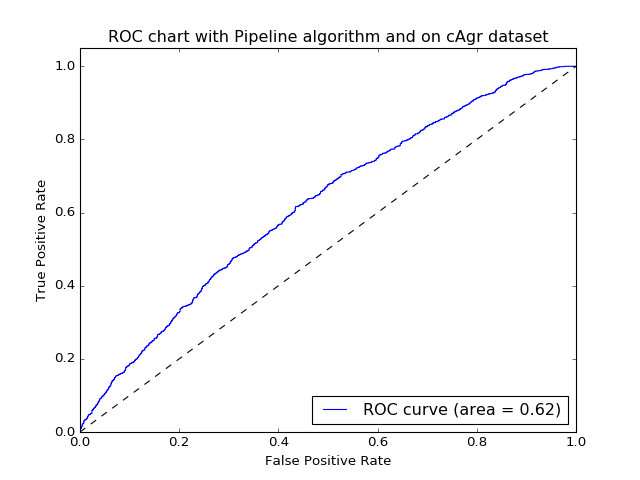

F1:  0.689549628334
Precision:  0.755316094192
Recall:  0.880513679509
Accuracy score:  0.578884934757

GRID SEARCH:
Best score: 0.569
Best parameters set:
	features__status__tf_idf_vect__ngram_range: (1, 1)

FOR: Pipeline: cCon/classifierNB
it is in predict proba


<IPython.core.display.Javascript object>


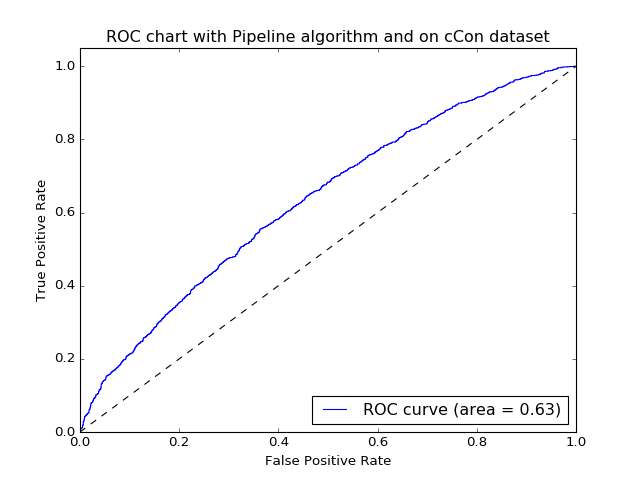

F1:  0.351187703773
Precision:  0.610692909509
Recall:  0.243382827631
Accuracy score:  0.586892052195

GRID SEARCH:
Best score: 0.575
Best parameters set:
	features__status__tf_idf_vect__ngram_range: (1, 1)

FOR: Pipeline: cOpn/classifierNB
it is in predict proba


<IPython.core.display.Javascript object>


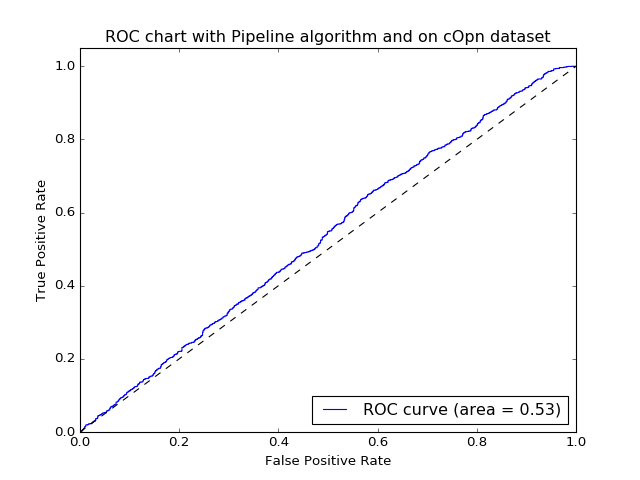

F1:  0.852961198094
Precision:  0.871810089021
Recall:  1.0
Accuracy score:  0.743772241993

GRID SEARCH:
Best score: 0.743
Best parameters set:
	features__status__tf_idf_vect__ngram_range: (1, 1)


In [15]:
#MNB
pipe_name , pipeline = pipeline_collection[2]
    
for reader_description, reader in data_reader_collection:
    apply_some_grid_search(pipe_name, pipeline, reader_description, reader)


FOR: Pipeline: cExt/classifierBNB
it is in predict proba


<IPython.core.display.Javascript object>


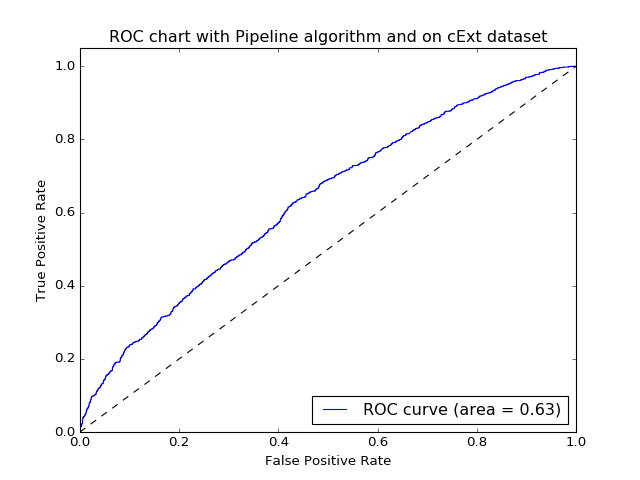

F1:  0.394444444444
Precision:  0.59004938244
Recall:  0.297693920335
Accuracy score:  0.612099644128

GRID SEARCH:
Best score: 0.593
Best parameters set:
	features__status__tf_idf_vect__ngram_range: (1, 1)

FOR: Pipeline: cNeu/classifierBNB
it is in predict proba


<IPython.core.display.Javascript object>


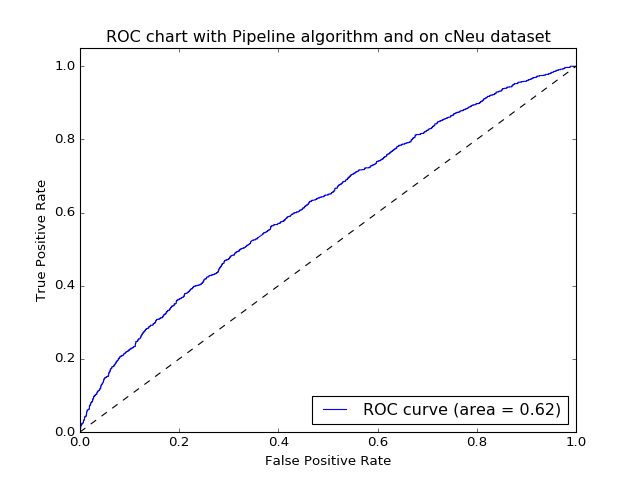

F1:  0.24380952381
Precision:  0.543587148248
Recall:  0.151898734177
Accuracy score:  0.646797153025

GRID SEARCH:
Best score: 0.633
Best parameters set:
	features__status__tf_idf_vect__ngram_range: (1, 1)

FOR: Pipeline: cAgr/classifierBNB
it is in predict proba


<IPython.core.display.Javascript object>


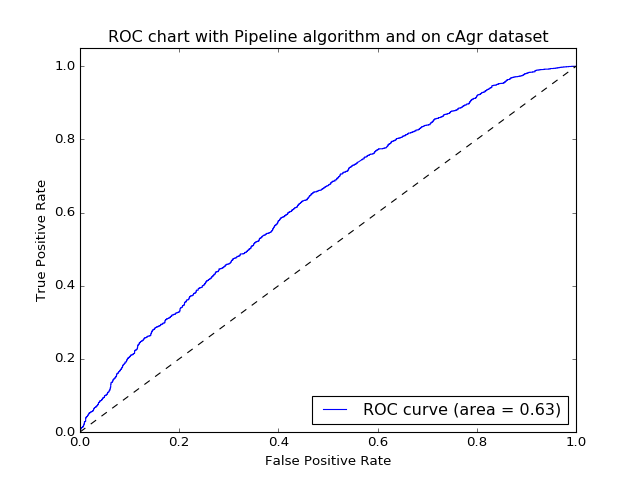

F1:  0.667157584683
Precision:  0.741088615622
Recall:  0.758793969849
Accuracy score:  0.597864768683

GRID SEARCH:
Best score: 0.571
Best parameters set:
	features__status__tf_idf_vect__ngram_range: (1, 1)

FOR: Pipeline: cCon/classifierBNB
it is in predict proba


<IPython.core.display.Javascript object>


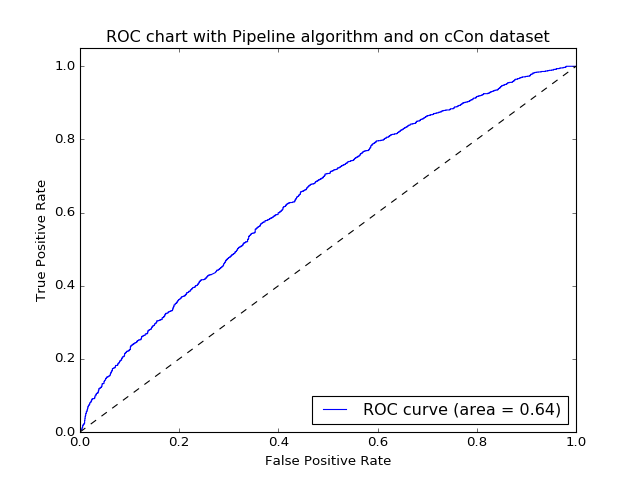

F1:  0.53393041681
Precision:  0.651119147146
Recall:  0.500322788896
Accuracy score:  0.598754448399

GRID SEARCH:
Best score: 0.581
Best parameters set:
	features__status__tf_idf_vect__ngram_range: (1, 1)

FOR: Pipeline: cOpn/classifierBNB
it is in predict proba


<IPython.core.display.Javascript object>


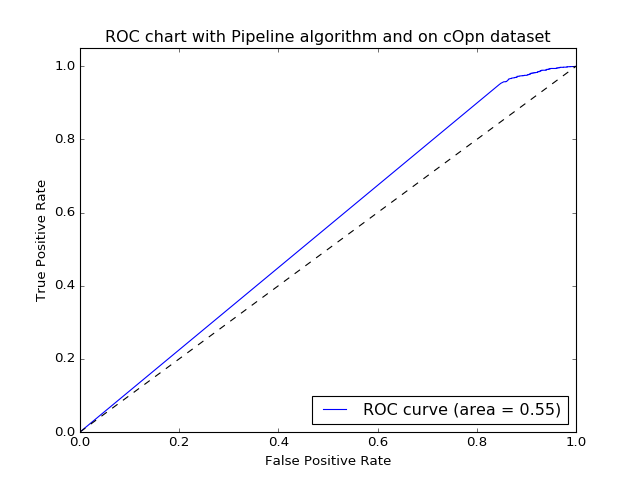

F1:  0.854266211604
Precision:  0.872982829779
Recall:  0.998802873105
Accuracy score:  0.746737841044

GRID SEARCH:
Best score: 0.743
Best parameters set:
	features__status__tf_idf_vect__ngram_range: (1, 2)


In [20]:
#BNB
pipe_name , pipeline = pipeline_collection[3]
    
for reader_description, reader in data_reader_collection:
    apply_some_grid_search(pipe_name, pipeline, reader_description, reader)

In [7]:
#LinearSVC
pipe_name , pipeline = pipeline_collection[0]
    
for reader_description, reader in data_reader_collection:
    apply_some_grid_search(pipe_name, pipeline, reader_description, reader)


FOR: Pipeline: cExt/classifierLinearSVC
F1:  0.486857142857
Precision:  0.60829610237
Recall:  0.446540880503
Accuracy score:  0.600533807829

GRID SEARCH:
Best score: 0.596
Best parameters set:
	features__derived_numeric__best: TruncatedSVD(algorithm='randomized', n_components=2, n_iter=5,
       random_state=5152, tol=0.0)
	features__status__tf_idf_vect__ngram_range: (1, 2)

FOR: Pipeline: cNeu/classifierLinearSVC
F1:  0.381322957198
Precision:  0.531838157238
Recall:  0.310126582278
Accuracy score:  0.622775800712

GRID SEARCH:
Best score: 0.630
Best parameters set:
	features__derived_numeric__best: TruncatedSVD(algorithm='randomized', n_components=2, n_iter=5,
       random_state=5152, tol=0.0)
	features__status__tf_idf_vect__ngram_range: (1, 2)

FOR: Pipeline: cAgr/classifierLinearSVC
F1:  0.616858237548
Precision:  0.715555723347
Recall:  0.629257398102
Accuracy score:  0.584816132859

GRID SEARCH:
Best score: 0.575
Best parameters set:
	features__derived_numeric__best: Truncate

In [8]:
#SVC
pipe_name , pipeline = pipeline_collection[1]
    
for reader_description, reader in data_reader_collection:
    apply_some_grid_search(pipe_name, pipeline, reader_description, reader)


FOR: Pipeline: cExt/classifierSVC


NameError: name 'plot_roc_curve' is not defined

In [8]:
#BNB
pipe_name , pipeline = pipeline_collection[3]
    
for reader_description, reader in data_reader_collection:
    apply_some_grid_search(pipe_name, pipeline, reader_description, reader)


FOR: Pipeline: cExt/classifierBNB


<IPython.core.display.Javascript object>

F1:  0.390697674419
Precision:  0.588733878808
Recall:  0.293501048218
Accuracy score:  0.611506524318

GRID SEARCH:
Best score: 0.605
Best parameters set:
	features__derived_numeric__best: TruncatedSVD(algorithm='randomized', n_components=2, n_iter=5,
       random_state=5152, tol=0.0)
	features__status__tf_idf_vect__ngram_range: (1, 1)

FOR: Pipeline: cNeu/classifierBNB


<IPython.core.display.Javascript object>

F1:  0.245859872611
Precision:  0.550512243015
Recall:  0.152689873418
Accuracy score:  0.648873072361

GRID SEARCH:
Best score: 0.641
Best parameters set:
	features__derived_numeric__best: TruncatedSVD(algorithm='randomized', n_components=2, n_iter=5,
       random_state=5152, tol=0.0)
	features__status__tf_idf_vect__ngram_range: (1, 1)

FOR: Pipeline: cAgr/classifierBNB


<IPython.core.display.Javascript object>

F1:  0.664707323047
Precision:  0.739221805451
Recall:  0.757677275265
Accuracy score:  0.594009489917

GRID SEARCH:
Best score: 0.579
Best parameters set:
	features__derived_numeric__best: TruncatedSVD(algorithm='randomized', n_components=2, n_iter=5,
       random_state=5152, tol=0.0)
	features__status__tf_idf_vect__ngram_range: (1, 1)

FOR: Pipeline: cCon/classifierBNB


<IPython.core.display.Javascript object>

F1:  0.339568345324
Precision:  0.621685693101
Recall:  0.228534538412
Accuracy score:  0.591637010676

GRID SEARCH:
Best score: 0.592
Best parameters set:
	features__derived_numeric__best: TruncatedSVD(algorithm='randomized', n_components=2, n_iter=5,
       random_state=5152, tol=0.0)
	features__status__tf_idf_vect__ngram_range: (1, 2)

FOR: Pipeline: cOpn/classifierBNB


<IPython.core.display.Javascript object>

F1:  0.854334854335
Precision:  0.877576297999
Recall:  0.971268954509
Accuracy score:  0.753855278766

GRID SEARCH:
Best score: 0.745
Best parameters set:
	features__derived_numeric__best: TruncatedSVD(algorithm='randomized', n_components=2, n_iter=5,
       random_state=5152, tol=0.0)
	features__status__tf_idf_vect__ngram_range: (1, 1)
